# Лабораторная работа 3
## Фильтр частиц
### Описание системы

В квадратной площадке длиной 100 метров находится мобильный робот. В углах площадки установлены радиомаяки. Робот может измерять расстояние до маяков. Погрешность измерений описывается нормальным распределением с нулевым математически ожиданием и погрешностью $\sigma = 15$. Известно, что начальное положение робота находится в диапазоне координат (0 -100, 0- 100). Начальная ориентация робота составляет $0 \pm 2$ градуса.

Робот функционирует следующим образом:

- Принимает от оператора требуемый угол поворота и дальность перемещения;
- Поворачивается на заданный угол;
- Проезжает заданную дистанцию;
- Измеряет расстояние до маяков;
- Рассчитывает свое положение.

Поворот робота на заданный угол происходит с нормально распределенной погрешностью с нулевым математическим ожиданием и средневадратическим отклонением $\sigma_{\theta} = 2$. Перемещение робота на заданную дистанцию происходит с нормально распределенной погрешностью с нулевым математическим ожиданием и средневадратическим отклонением $\sigma_{l} = 15$.  Требуется построить фильтр частиц для повышения точности локализации робота.

### Задание

- Задать начальное положение робота и средневадратические отклонения;
- Задать не менее 5 команд на перемещение робота;
- Построить траеткторию движения робота с учетом погрешностей;
- Построить фильтр частиц для робота;
- Построить траеткорию движения робота, положения частиц и оценку положения робота после выполнения каждой из команд;
- Выполнить предыдущие пункты для трех различных начальных положений, среднеквадратических отклонений, количества частиц и траекторий движения.

### ***Часть 1.*** Задание начального положения робота и среднеквадратического отклонения

Text(0.5, 1.0, 'Начальное положение робота')

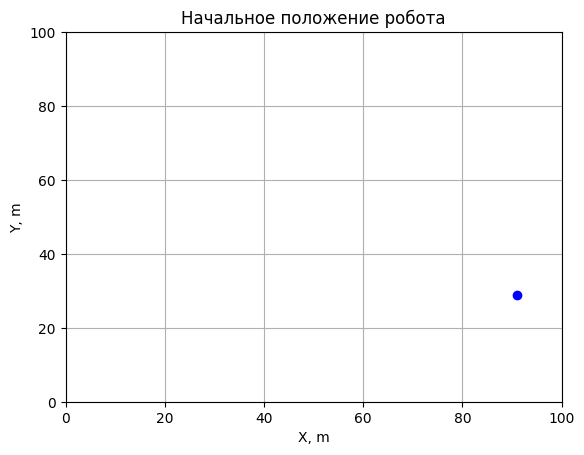

In [143]:
import numpy as np
import matplotlib.pyplot as plt


seed = 90
np.random.seed(seed)

a = 100  # ширина поля
b = 100  # длина

beacons = [[0,0], [0, b], [a, b], [a, 0]]  # расположение маяков по углам нашей карты

# датчик
mu_z = 0
sigma_z = 15

# поворот робота
mu_turn = 0
sigma_turn = 2

# перемещение робота
mu_move = 0
sigma_move = 15

# начальное положение
x_0, y_0 = np.random.randint(0, a), np.random.randint(0, b)
ang_0 = np.random.uniform(-2, 2)

plt.scatter(x_0, y_0, c='b', marker='o')
plt.xlim([0, a])
plt.ylim([0, b])
plt.grid()
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.title('Начальное положение робота')

### ***Часть 2.*** Задать не менее 5 команд на перемещение робота

In [144]:
distance = [20, 20, 30, 15, 10]
angle_of_turn = [45, 30, -60, 30, 35]  # в градусах величина поворота


# для удобства создадим функцию для перемещения робота
def movement_of_robot(x_0, y_0, ang_0, distance, angle_of_turn):
    ang = np.deg2rad(np.rad2deg(ang_0) + angle_of_turn + np.random.normal(0, sigma_turn))  # учитываем начальный угол, погрешность начального угла и погрешность при повороте
    rand_move = np.random.normal(distance, sigma_move)  # погрешность перемещения
    x  = x_0 + np.cos(ang) * rand_move  # учитываем наши погрешности по повороту и по перемещению
    y = y_0 + np.sin(ang) * rand_move  

    ang_com = np.deg2rad(np.rad2deg(ang_0) + angle_of_turn)  # итоговый угол 
    x_com = x_0 + np.cos(ang_com) * distance  # командные значения перемещений без погрешностей
    y_com = y_0 + np.sin(ang_com) * distance

    return x, y, ang, x_com, y_com, ang_com

# инициализируем начальные значения для массивов данных
x_massive, y_massive, ang_massive, x_com_massive, y_com_massive, ang_com_massive = [x_0], [y_0], [ang_0], [x_0], [y_0], [ang_0]

for i in range(len(distance)):
    x_temp, y_temp, ang_temp, x_com_temp, y_com_temp, ang_com_temp = movement_of_robot(x_0 = x_com_massive[-1],
                                                                                       y_0 = y_massive[-1],
                                                                                       ang_0 = ang_massive[-1],
                                                                                       distance=distance[i],
                                                                                       angle_of_turn=angle_of_turn[i])
    x_massive.append(x_temp)
    y_massive.append(y_temp)
    ang_massive.append(ang_temp) 
    x_com_massive.append(x_com_temp)
    y_com_massive.append(y_com_temp)
    ang_com_massive.append(ang_com_temp)



### ***Часть 3.*** Построить траекторию движения робота с учётом погрешности

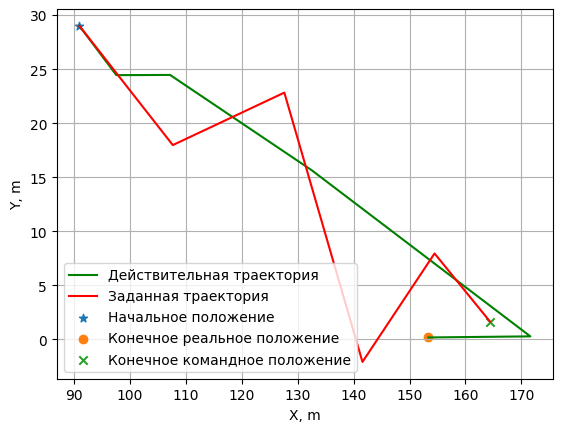

In [145]:
plt.plot(x_massive, y_massive, c ='g')
plt.plot(x_com_massive, y_com_massive, c='r')
plt.scatter(x_0, y_0, marker='*')
plt.scatter(x_massive[-1], y_massive[-1], marker='o')
plt.scatter(x_com_massive[-1], y_com_massive[-1], marker='x')
plt.xlabel('X, m')
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.grid()
plt.legend(['Действительная траектория', 'Заданная траектория','Начальное положение', 'Конечное реальное положение', 'Конечное командное положение'])

### ***Часть 4.*** Построить фильтр частиц для робота

Напишем функцию, которая позволит рассчитывать расстояние от робота до маяков с помощью датчика с учётом его погрешности

In [175]:
def beacon_distance(beacons, x, y, error=1):
    if error == 0:
        meas_error = 0
    else:
        meas_error = np.random.normal(0, sigma_z)

    measurements = []

    for i in range(len(beacons)):
        measurements.append(np.sqrt((beacons[i][0] - x) ** 2 + (beacons[i][1] - y) ** 2) + meas_error)
    
    return measurements

Создадим функцию для расчёта вероятности получения измерений для каждой из частиц

In [147]:
def prob(distance, measurements):
    return 1/np.sqrt(2 * np.pi * sigma_z) * np.exp(-(distance - measurements) ** 2 / sigma_z)

И теперь напишем функцию, которая перераспределяет веса в соответствии с вероятностью. То есть, считается вес для каждой частицы для каждого маяка. Затем, вероятности между собой умножаются и находится для каждой частицы итоговый вес путём деления на сумму всех висов (== доля)

In [174]:
def weight_calc(particles, weights, beacons, robot_measurement, numb_of_particles):
    for i in range(numb_of_particles):
        particles_dist = beacon_distance(beacons, particles[i, 0], particles[i, 1], error=0)
        weights[i] = prob(particles_dist[0], robot_measurement[0]) * prob(particles_dist[1], robot_measurement[1])* prob(particles_dist[2], robot_measurement[2]) * prob(particles_dist[3], robot_measurement[3])
    weights = weights / np.sum(weights)

    return weights

Проводим отсев, определяя нужные нам частицы и их веса

In [149]:
def resample(particles, weights):
    newParticles = []
    newWeights = []
    index = np.random.randint(0, len(particles))
    betta = 0
    for _ in range(len(particles)):
        betta = betta + np.random.uniform(0, 2*max(weights))
        while betta > weights[index]:
            betta = betta - weights[index]
            index = (index + 1) % len(particles)
        newParticles.append(particles[index])
        newWeights.append(weights[index])
    newWeights = newWeights / np.sum(newWeights)

    return np.array(newParticles), newWeights

Оценка положения на основе координат частиц и веса каждой из них

In [150]:
def estimation(particles, weights):
    est_x = 0
    est_y = 0
    for i in range(len(particles)):
        est_x += particles[i, 0] * weights[i]
        est_y += particles[i, 1] * weights[i]
    return est_x, est_y

Ячейка ниже работает следующим образом:\
Генерируем начальное положение частиц и делаем их веса одинаковыми. Далее проводим замер расстояния до маяков роботом. Далее, с учётом функций выше, проводим замер расстояния до маяков и расчёт весов для каждой из частиц, проводим отсев лишних частиц и выбираем только те, которые ближе всего к роботу. Далее, на основе частиц проводим оценку положения робота после каждой команды и строим графики с реальным положением робота, с полезными частицами и всеми остальными частицами

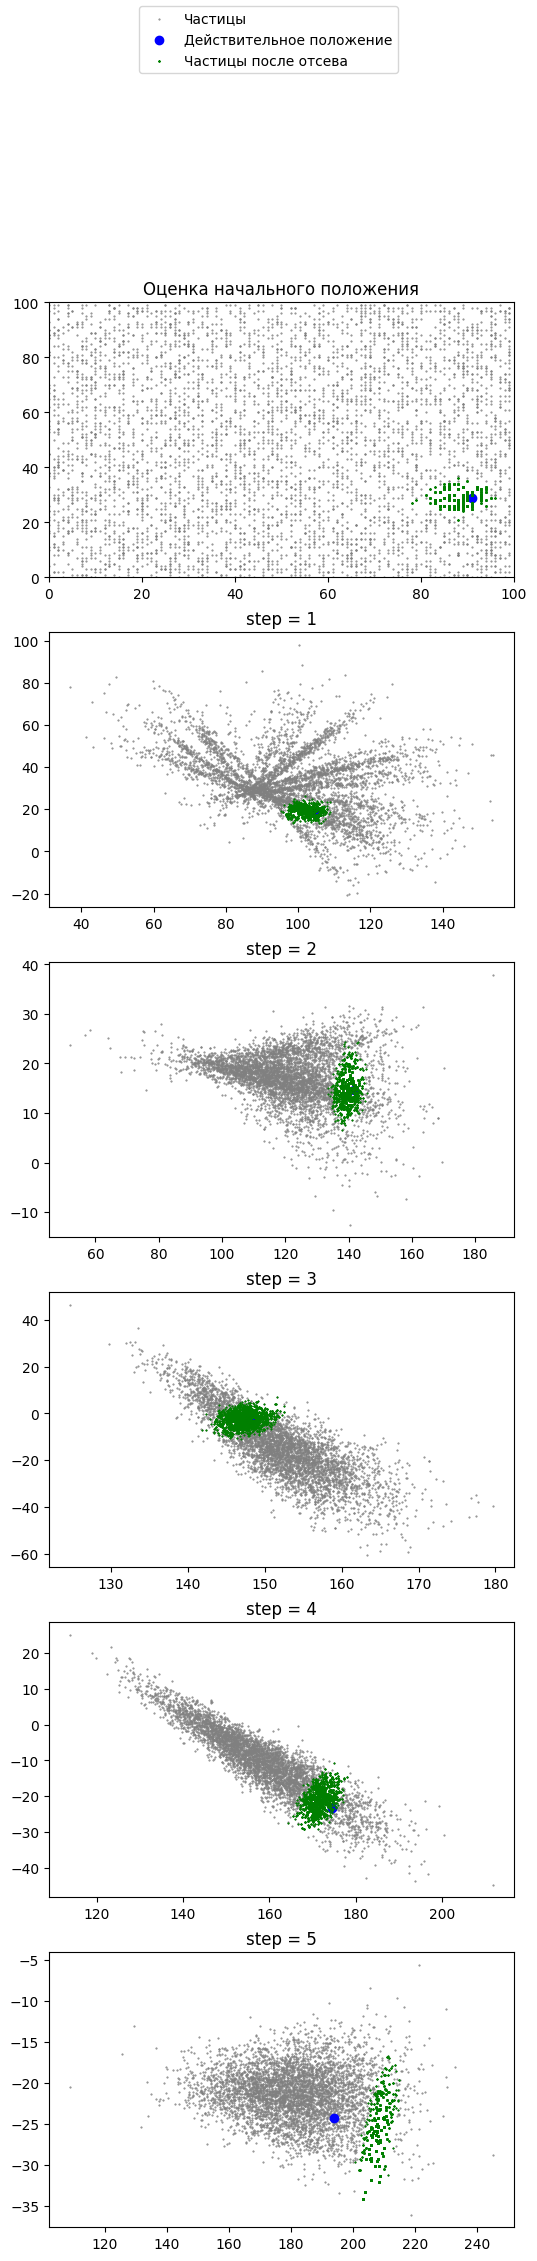

In [151]:
N_particles = 5000
x = x_0
y = y_0
ang = ang_0

particles = np.zeros((N_particles, 3))

for i in range(N_particles):
    particles[i][0] = np.random.randint(0, 100)
    particles[i][1] = np.random.randint(0, 100)
    particles[i][2] = np.random.uniform(-2, 2)


fig, axs = plt.subplots(nrows=6, figsize=(6, 25))

axs[0].scatter(particles[:, 0], particles[:, 1], c='grey', marker='.', s=1)

weights = np.ones(N_particles) / N_particles

measurements = beacon_distance(beacons=beacons, x=x, y=y, error=1)

weights = weight_calc(particles=particles, weights=weights,
                    beacons=beacons, robot_measurement=measurements,
                    numb_of_particles=N_particles)
particles, weights = resample(particles=particles, weights=weights)

x_est, y_est = estimation(particles=particles, weights=weights)

x_true, y_true, x_est_fin, y_est_fin = [x], [y], [x_est], [y_est]


axs[0].scatter(x_true, y_true, color='blue', marker='o')
axs[0].scatter(particles[:, 0], particles[:, 1], c='g', marker='*', s=1)
axs[0].set_xlim(0, 100)
axs[0].set_ylim(0, 100)
axs[0].set_title('Оценка начального положения')
fig.legend(['Частицы', 'Действительное положение', 'Частицы после отсева'],loc='upper center')

for command in range(len(distance)):
    x, y, ang, _, _, _ = movement_of_robot(x, y, ang, distance=distance[command], angle_of_turn=angle_of_turn[command])
    x_true.append(x)
    y_true.append(y)

    for i in range(N_particles):
        particles[i, 0], particles[i, 1], particles[i, 2], _, _, _ = movement_of_robot(particles[i, 0], particles[i, 1],
                                                                                        particles[i, 2], distance=distance[command],
                                                                                        angle_of_turn=angle_of_turn[command])
    axs[command+1].scatter(particles[:, 0], particles[:, 1], c='grey', marker='.', s=1)

    measurements = beacon_distance(beacons=beacons, x=x, y=y, error=1)
    weights = weight_calc(particles=particles, weights=weights,
                    beacons=beacons, robot_measurement=measurements,
                    numb_of_particles=N_particles)
    particles, weights = resample(particles=particles, weights=weights)

    x_est, y_est = estimation(particles=particles, weights=weights)

    x_est_fin.append(x_est)
    y_est_fin.append(y_est)

    axs[command+1].scatter(x_true[-1], y_true[-1], color='blue', marker='o',)
    axs[command+1].scatter(particles[:, 0], particles[:, 1], c='g', marker='*', s=0.2)
    axs[command+1].set_title('step = {}'.format(command+1))
    


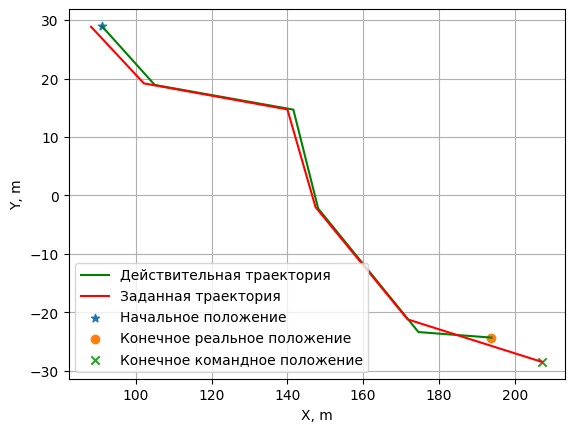

In [152]:
plt.plot(x_true, y_true, c ='g')
plt.plot(x_est_fin, y_est_fin, c='r')
plt.scatter(x_0, y_0, marker='*')
plt.scatter(x_true[-1], y_true[-1], marker='o')
plt.scatter(x_est_fin[-1], y_est_fin[-1], marker='x')
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.grid()
plt.legend(['Действительная траектория', 'Заданная траектория','Начальное положение', 'Конечное реальное положение', 'Конечное командное положение'])

### *Часть 5.* Выполнить предыдущие пункты для трех различных начальных положений, среднеквадратических отклонений, количества частиц и траекторий движения.

Сначала изменим количество частиц и выберем случайное начального положения

Text(0.5, 1.0, 'Начальное положение робота')

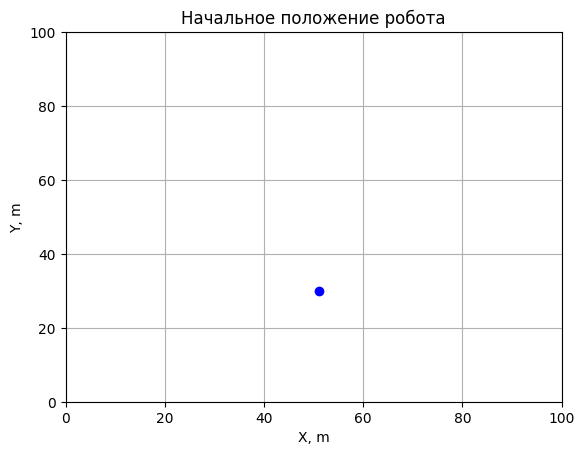

In [157]:
import numpy as np
import matplotlib.pyplot as plt

a = 100  # ширина поля
b = 100  # длина

beacons = [[0,0], [0, b], [a, b], [a, 0]]  # расположение маяков по углам нашей карты

# датчик
mu_z = 0
sigma_z = 15

# поворот робота
mu_turn = 0
sigma_turn = 2

# перемещение робота
mu_move = 0
sigma_move = 15

# начальное положение
x_0, y_0 = np.random.randint(0, a), np.random.randint(0, b)
ang_0 = np.random.uniform(-2, 2)


distance = [40, 5, 10, 5, 15]
angle_of_turn = [15, 20, 10, -80, 70]  # в градусах величина поворота


plt.scatter(x_0, y_0, c='b', marker='o')
plt.xlim([0, a])
plt.ylim([0, b])
plt.grid()
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.title('Начальное положение робота')


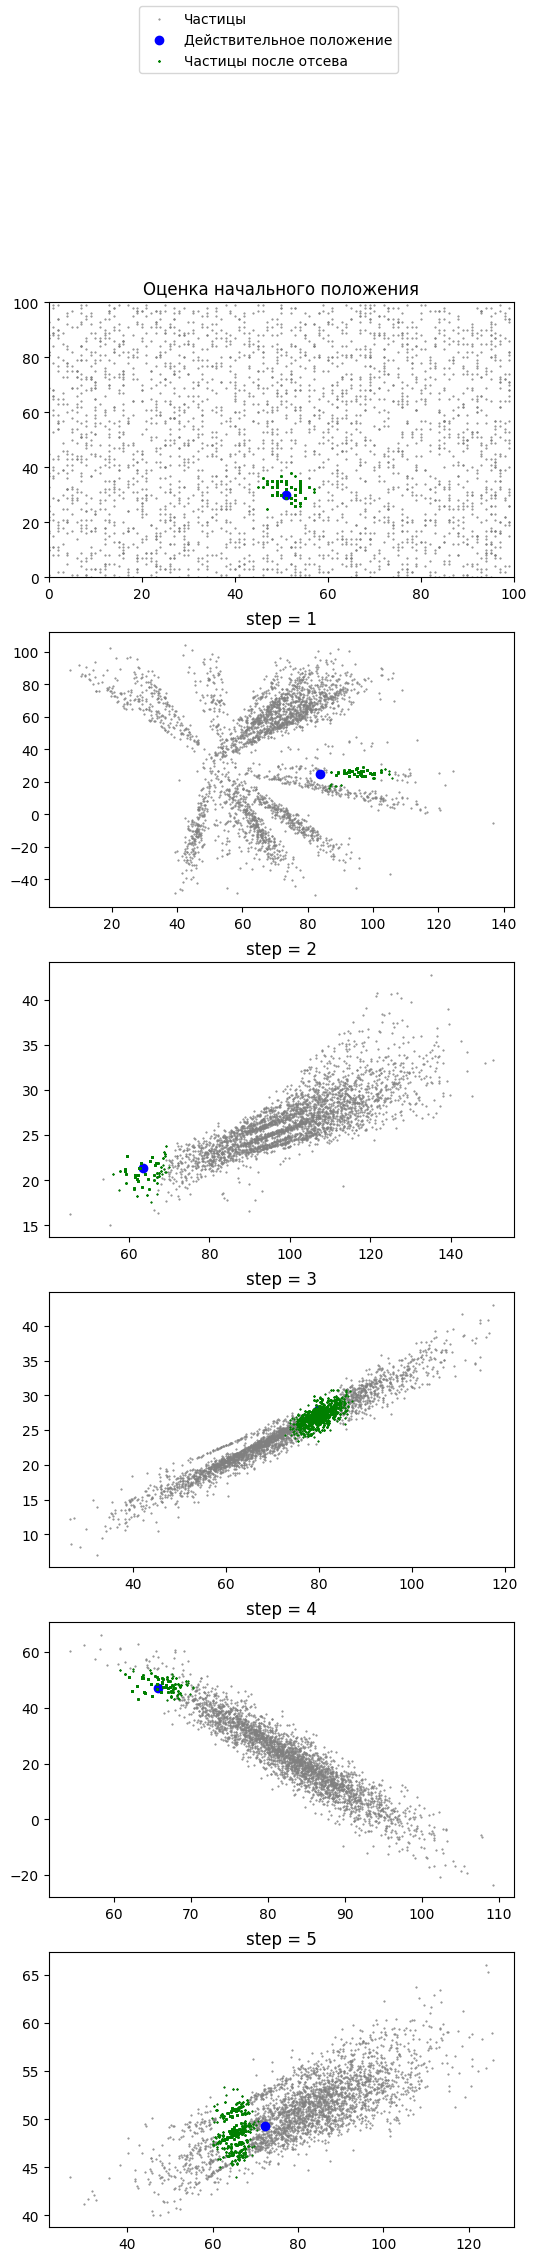

In [158]:
N_particles = 3000
x = x_0
y = y_0
ang = ang_0

particles = np.zeros((N_particles, 3))

for i in range(N_particles):
    particles[i][0] = np.random.randint(0, 100)
    particles[i][1] = np.random.randint(0, 100)
    particles[i][2] = np.random.uniform(-2, 2)


fig, axs = plt.subplots(nrows=6, figsize=(6, 25))

axs[0].scatter(particles[:, 0], particles[:, 1], c='grey', marker='.', s=1)

weights = np.ones(N_particles) / N_particles

measurements = beacon_distance(beacons=beacons, x=x, y=y, error=1)

weights = weight_calc(particles=particles, weights=weights,
                    beacons=beacons, robot_measurement=measurements,
                    numb_of_particles=N_particles)
particles, weights = resample(particles=particles, weights=weights)

x_est, y_est = estimation(particles=particles, weights=weights)

x_true, y_true, x_est_fin, y_est_fin = [x], [y], [x_est], [y_est]


axs[0].scatter(x_true, y_true, color='blue', marker='o')
axs[0].scatter(particles[:, 0], particles[:, 1], c='g', marker='*', s=1)
axs[0].set_xlim(0, 100)
axs[0].set_ylim(0, 100)
axs[0].set_title('Оценка начального положения')
fig.legend(['Частицы', 'Действительное положение', 'Частицы после отсева'],loc='upper center')

for command in range(len(distance)):
    x, y, ang, _, _, _ = movement_of_robot(x, y, ang, distance=distance[command], angle_of_turn=angle_of_turn[command])
    x_true.append(x)
    y_true.append(y)

    for i in range(N_particles):
        particles[i, 0], particles[i, 1], particles[i, 2], _, _, _ = movement_of_robot(particles[i, 0], particles[i, 1],
                                                                                        particles[i, 2], distance=distance[command],
                                                                                        angle_of_turn=angle_of_turn[command])
    axs[command+1].scatter(particles[:, 0], particles[:, 1], c='grey', marker='.', s=1)

    measurements = beacon_distance(beacons=beacons, x=x, y=y, error=1)
    weights = weight_calc(particles=particles, weights=weights,
                    beacons=beacons, robot_measurement=measurements,
                    numb_of_particles=N_particles)
    particles, weights = resample(particles=particles, weights=weights)

    x_est, y_est = estimation(particles=particles, weights=weights)

    x_est_fin.append(x_est)
    y_est_fin.append(y_est)

    axs[command+1].scatter(x_true[-1], y_true[-1], color='blue', marker='o',)
    axs[command+1].scatter(particles[:, 0], particles[:, 1], c='g', marker='*', s=0.2)
    axs[command+1].set_title('step = {}'.format(command+1))

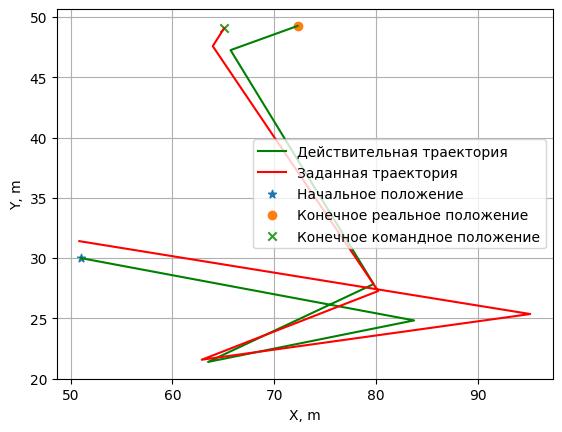

In [159]:
plt.plot(x_true, y_true, c ='g')
plt.plot(x_est_fin, y_est_fin, c='r')
plt.scatter(x_0, y_0, marker='*')
plt.scatter(x_true[-1], y_true[-1], marker='o')
plt.scatter(x_est_fin[-1], y_est_fin[-1], marker='x')
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.grid()
plt.legend(['Действительная траектория', 'Заданная траектория','Начальное положение', 'Конечное реальное положение', 'Конечное командное положение'])

Теперь изменим среднеквардратические отклонения для той же траектории и того же числа частиц

Text(0.5, 1.0, 'Начальное положение робота')

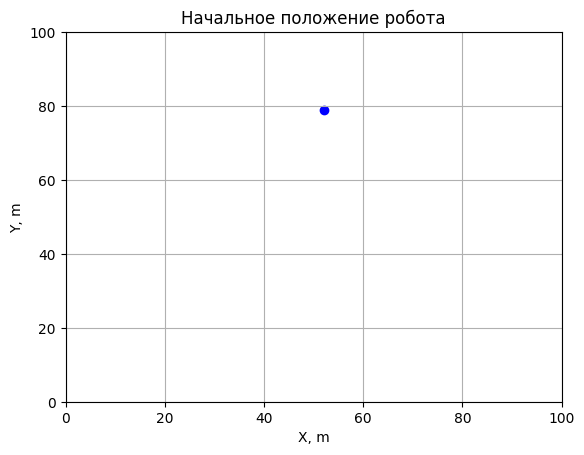

In [160]:
import numpy as np
import matplotlib.pyplot as plt

a = 100  # ширина поля
b = 100  # длина

beacons = [[0,0], [0, b], [a, b], [a, 0]]  # расположение маяков по углам нашей карты

# датчик
mu_z = 0
sigma_z = 5

# поворот робота
mu_turn = 0
sigma_turn = 5

# перемещение робота
mu_move = 0
sigma_move = 25

# начальное положение
x_0, y_0 = np.random.randint(0, a), np.random.randint(0, b)
ang_0 = np.random.uniform(-2, 2)


distance = [40, 5, 10, 5, 15]
angle_of_turn = [15, 20, 10, -80, 70]  # в градусах величина поворота


plt.scatter(x_0, y_0, c='b', marker='o')
plt.xlim([0, a])
plt.ylim([0, b])
plt.grid()
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.title('Начальное положение робота')

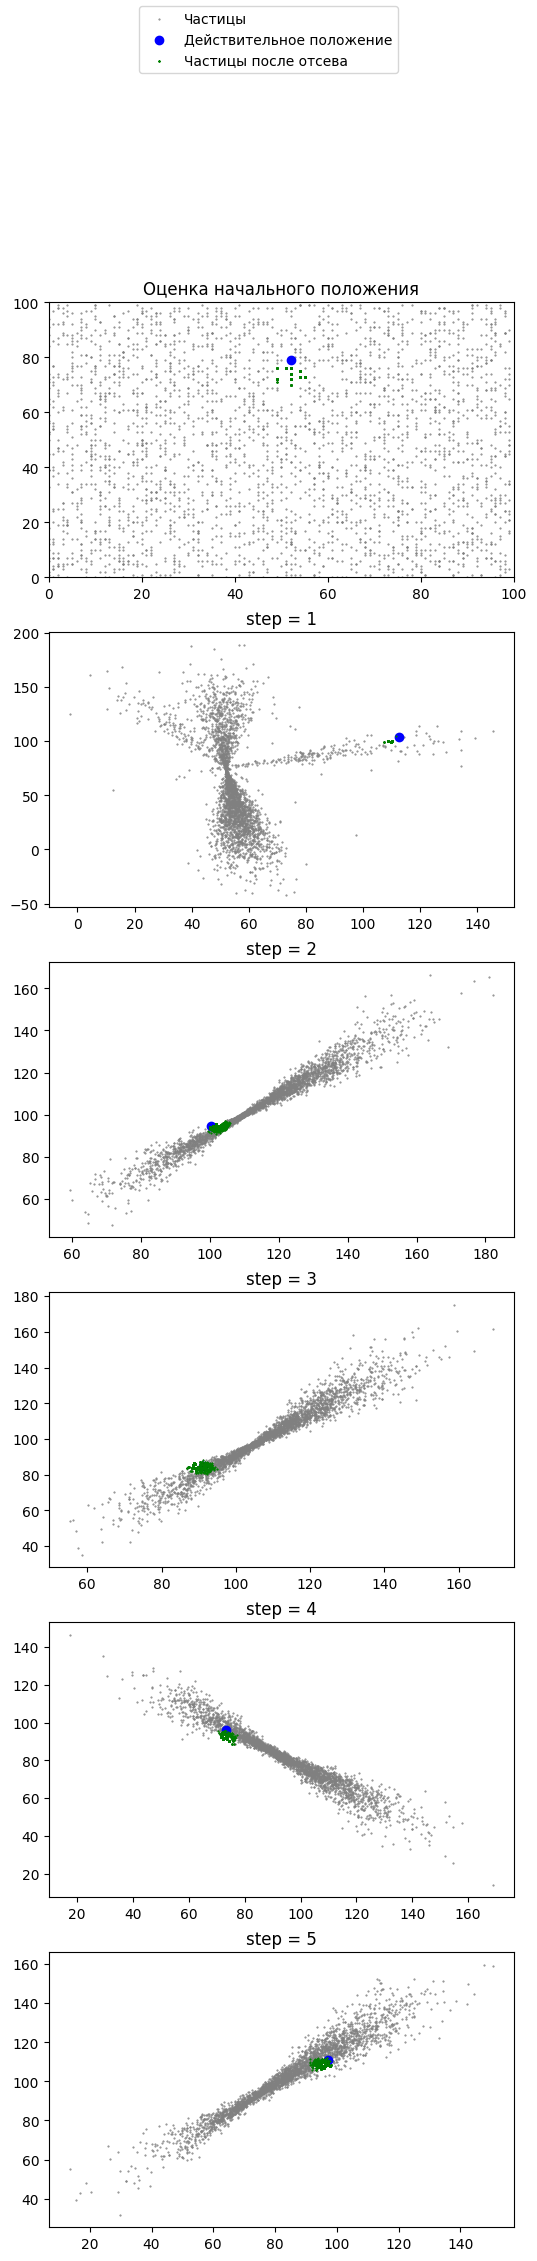

In [161]:
N_particles = 3000
x = x_0
y = y_0
ang = ang_0

particles = np.zeros((N_particles, 3))

for i in range(N_particles):
    particles[i][0] = np.random.randint(0, 100)
    particles[i][1] = np.random.randint(0, 100)
    particles[i][2] = np.random.uniform(-2, 2)


fig, axs = plt.subplots(nrows=6, figsize=(6, 25))

axs[0].scatter(particles[:, 0], particles[:, 1], c='grey', marker='.', s=1)

weights = np.ones(N_particles) / N_particles

measurements = beacon_distance(beacons=beacons, x=x, y=y, error=1)

weights = weight_calc(particles=particles, weights=weights,
                    beacons=beacons, robot_measurement=measurements,
                    numb_of_particles=N_particles)
particles, weights = resample(particles=particles, weights=weights)

x_est, y_est = estimation(particles=particles, weights=weights)

x_true, y_true, x_est_fin, y_est_fin = [x], [y], [x_est], [y_est]


axs[0].scatter(x_true, y_true, color='blue', marker='o')
axs[0].scatter(particles[:, 0], particles[:, 1], c='g', marker='*', s=1)
axs[0].set_xlim(0, 100)
axs[0].set_ylim(0, 100)
axs[0].set_title('Оценка начального положения')
fig.legend(['Частицы', 'Действительное положение', 'Частицы после отсева'],loc='upper center')

for command in range(len(distance)):
    x, y, ang, _, _, _ = movement_of_robot(x, y, ang, distance=distance[command], angle_of_turn=angle_of_turn[command])
    x_true.append(x)
    y_true.append(y)

    for i in range(N_particles):
        particles[i, 0], particles[i, 1], particles[i, 2], _, _, _ = movement_of_robot(particles[i, 0], particles[i, 1],
                                                                                        particles[i, 2], distance=distance[command],
                                                                                        angle_of_turn=angle_of_turn[command])
    axs[command+1].scatter(particles[:, 0], particles[:, 1], c='grey', marker='.', s=1)

    measurements = beacon_distance(beacons=beacons, x=x, y=y, error=1)
    weights = weight_calc(particles=particles, weights=weights,
                    beacons=beacons, robot_measurement=measurements,
                    numb_of_particles=N_particles)
    particles, weights = resample(particles=particles, weights=weights)

    x_est, y_est = estimation(particles=particles, weights=weights)

    x_est_fin.append(x_est)
    y_est_fin.append(y_est)

    axs[command+1].scatter(x_true[-1], y_true[-1], color='blue', marker='o',)
    axs[command+1].scatter(particles[:, 0], particles[:, 1], c='g', marker='*', s=0.2)
    axs[command+1].set_title('step = {}'.format(command+1))

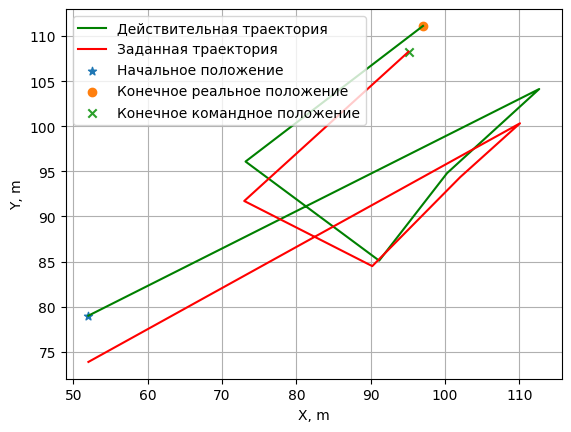

In [162]:
plt.plot(x_true, y_true, c ='g')
plt.plot(x_est_fin, y_est_fin, c='r')
plt.scatter(x_0, y_0, marker='*')
plt.scatter(x_true[-1], y_true[-1], marker='o')
plt.scatter(x_est_fin[-1], y_est_fin[-1], marker='x')
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.grid()
plt.legend(['Действительная траектория', 'Заданная траектория','Начальное положение', 'Конечное реальное положение', 'Конечное командное положение'])

Теперь сделаем датчик менее точным, но увеличим число частиц

Text(0.5, 1.0, 'Начальное положение робота')

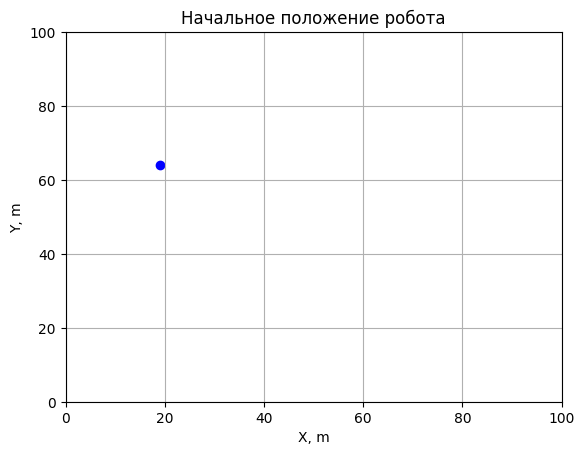

In [176]:
import numpy as np
import matplotlib.pyplot as plt

a = 100  # ширина поля
b = 100  # длина

beacons = [[0,0], [0, b], [a, b], [a, 0]]  # расположение маяков по углам нашей карты

# датчик
mu_z = 0
sigma_z = 25

# поворот робота
mu_turn = 0
sigma_turn = 5

# перемещение робота
mu_move = 0
sigma_move = 25

# начальное положение
x_0, y_0 = np.random.randint(0, a), np.random.randint(0, b)
ang_0 = np.random.uniform(-2, 2)


distance = [40, 5, 10, 5, 15]
angle_of_turn = [15, 20, 10, -80, 70]  # в градусах величина поворота


plt.scatter(x_0, y_0, c='b', marker='o')
plt.xlim([0, a])
plt.ylim([0, b])
plt.grid()
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.title('Начальное положение робота')

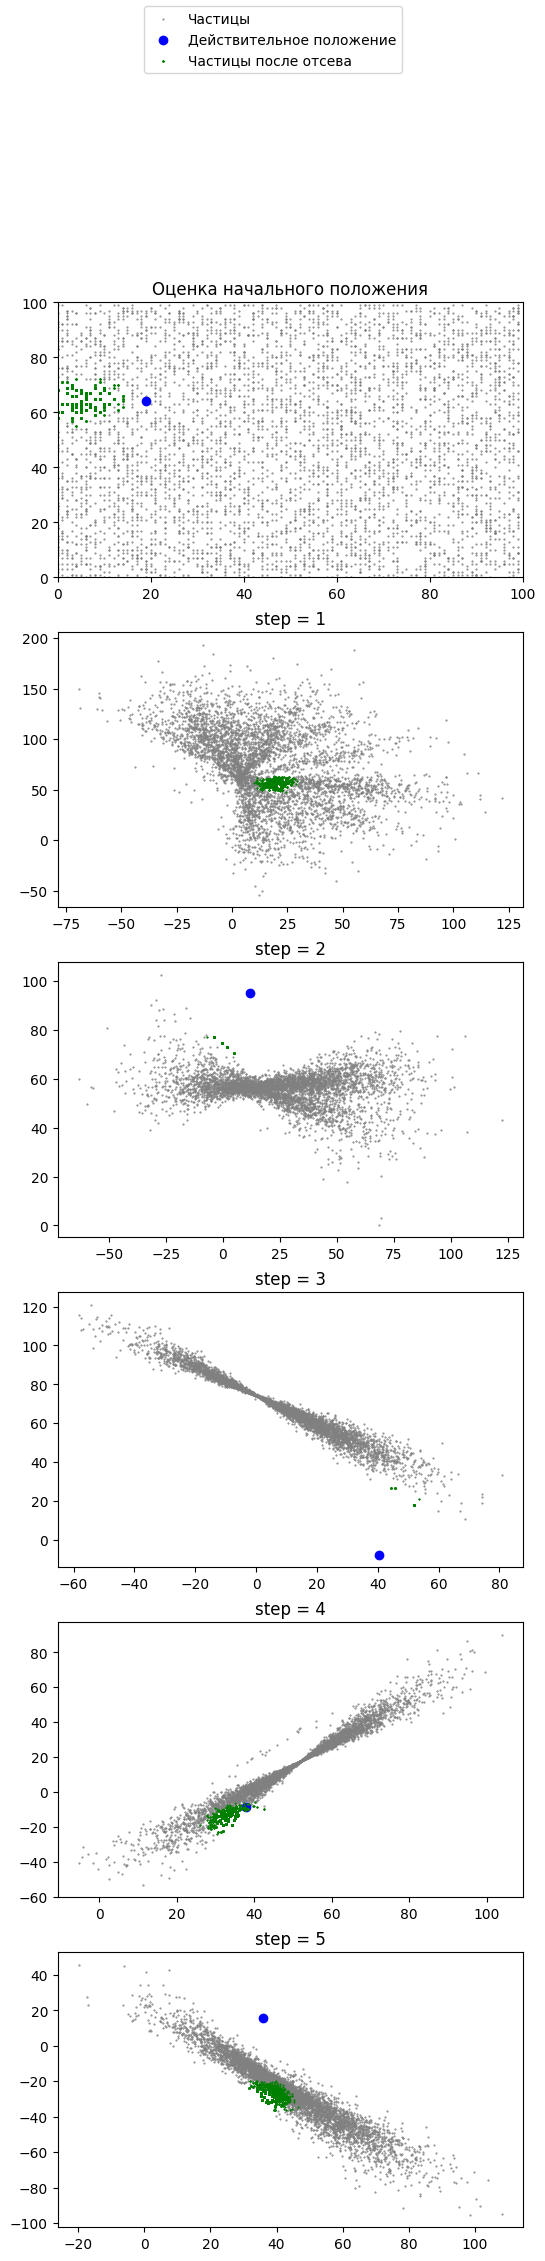

In [177]:
N_particles = 5000
x = x_0
y = y_0
ang = ang_0

particles = np.zeros((N_particles, 3))

for i in range(N_particles):
    particles[i][0] = np.random.randint(0, 100)
    particles[i][1] = np.random.randint(0, 100)
    particles[i][2] = np.random.uniform(-2, 2)


fig, axs = plt.subplots(nrows=6, figsize=(6, 25))

axs[0].scatter(particles[:, 0], particles[:, 1], c='grey', marker='.', s=1)

weights = np.ones(N_particles) / N_particles

measurements = beacon_distance(beacons=beacons, x=x, y=y, error=1)

weights = weight_calc(particles=particles, weights=weights,
                    beacons=beacons, robot_measurement=measurements,
                    numb_of_particles=N_particles)
particles, weights = resample(particles=particles, weights=weights)

x_est, y_est = estimation(particles=particles, weights=weights)

x_true, y_true, x_est_fin, y_est_fin = [x], [y], [x_est], [y_est]


axs[0].scatter(x_true, y_true, color='blue', marker='o')
axs[0].scatter(particles[:, 0], particles[:, 1], c='g', marker='*', s=1)
axs[0].set_xlim(0, 100)
axs[0].set_ylim(0, 100)
axs[0].set_title('Оценка начального положения')
fig.legend(['Частицы', 'Действительное положение', 'Частицы после отсева'],loc='upper center')

for command in range(len(distance)):
    x, y, ang, _, _, _ = movement_of_robot(x, y, ang, distance=distance[command], angle_of_turn=angle_of_turn[command])
    x_true.append(x)
    y_true.append(y)

    for i in range(N_particles):
        particles[i, 0], particles[i, 1], particles[i, 2], _, _, _ = movement_of_robot(particles[i, 0], particles[i, 1],
                                                                                        particles[i, 2], distance=distance[command],
                                                                                        angle_of_turn=angle_of_turn[command])
    axs[command+1].scatter(particles[:, 0], particles[:, 1], c='grey', marker='.', s=1)

    measurements = beacon_distance(beacons=beacons, x=x, y=y, error=1)
    weights = weight_calc(particles=particles, weights=weights,
                    beacons=beacons, robot_measurement=measurements,
                    numb_of_particles=N_particles)
    particles, weights = resample(particles=particles, weights=weights)

    x_est, y_est = estimation(particles=particles, weights=weights)

    x_est_fin.append(x_est)
    y_est_fin.append(y_est)

    axs[command+1].scatter(x_true[-1], y_true[-1], color='blue', marker='o',)
    axs[command+1].scatter(particles[:, 0], particles[:, 1], c='g', marker='*', s=0.2)
    axs[command+1].set_title('step = {}'.format(command+1))

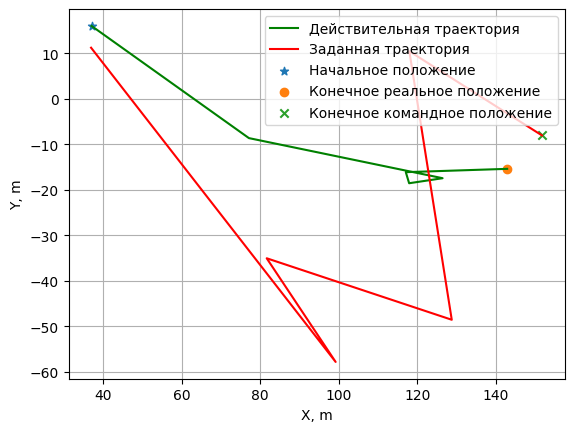

In [173]:
plt.plot(x_true, y_true, c ='g')
plt.plot(x_est_fin, y_est_fin, c='r')
plt.scatter(x_0, y_0, marker='*')
plt.scatter(x_true[-1], y_true[-1], marker='o')
plt.scatter(x_est_fin[-1], y_est_fin[-1], marker='x')
plt.xlabel('X, m')
plt.ylabel('Y, m')
plt.grid()
plt.legend(['Действительная траектория', 'Заданная траектория','Начальное положение', 'Конечное реальное положение', 'Конечное командное положение'])

## *Выводы:*


В ходе выполнения лабораторной работы были выполнены следующие шаги:\
+ Задано начальное положение робота и среднеквадратические отклонения в соответствии с условиями задачи
+ Задано 5 команд на перемещение
+ Построены траектории движения с учётом погрешностей и без них
+ Построен фильтр частиц для робота и графики с положением робота, частицами после каждой из команд\
  \
Эти процедуры были выполнены для разного числа частиц, для случайных начальных положений и для разных траекторий, а также для разных значений случайных отклонений. На основании этих шагов можно сделать следующие выводы:
+ Как таковое начальное положение робота и его траектория не оказывают влияние на работу фильтра частиц - можно использовать случайную точку старта и задавать с помощью последовательности команд разные траектории
+ Большое количество частиц позволяет более точно определять положение робота, однако при этом значительно увеличивается время выполнения вычислений
+ При этом большое числа частиц позволяет роботу с неточным датчиком более качественно определять свою позицию. В то же время наилучший результат всё же получился при большом числе частиц и средних показаниях датчика